#  Loan Default Probability (Charged Off Prediction)

- **Target**: Loan Status (Charged Off vs. Current/Fully Paid)

- **Predictors**: Grade, Annual Income, DTI, Loan Amount, Interest Rate.

- **Rationale**: Predict the likelihood of a loan being charged off (i.e., defaulting) based on factors like financial health (DTI, income) and loan terms. This can help in identifying high-risk loans early.

## Data Exploration

In [15]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter



In [16]:
df = pd.read_csv('/Users/DELL/Desktop/Projects/Bank Loan Report/myworkspace/financial_loan.csv')

## Feature Engineer

In [17]:
# Define the target and features
X = df[['grade', 'annual_income', 'dti', 'loan_amount', 'int_rate']]

# Convert Loan Status to a binary format (1 = Charged Off, 0 = Current/Fully Paid)
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
y = df['loan_status']


In [18]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenate training and testing sets for encoding
X_combined = pd.concat([X_train, X_test], axis=0)

# Apply one-hot encoding to categorical variables
X_combined_encoded = pd.get_dummies(X_combined, drop_first=True)

# Split back into X_train and X_test
X_train_encoded = X_combined_encoded[:len(X_train)]
X_test_encoded = X_combined_encoded[len(X_train):]

# Scale the encoded features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

/Users/DELL/Desktop/Projects/Bank Loan Report/myworkspace/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


# Select a Baseline Model:

In the following cells we implement:

1. Logistic regression

2. Decision tree

3. Random forest

4. Gradient boosting ensemble


After training the models on the training data, we will assess their performance on the validation set by precision, recall, f1-score and confusion matrix (especially maximizing recall for `Charged Off`) to align with our rationale.

The class `1` corresponds to Charged Off, while class `0` represents Current/Fully Paid, so the models struggle with recall for class `1`. Therefore, we apply Class Weighting to  adjusts the penalty for misclassifying the minority class, helping the model focus more on class `1`.

### Logistic Regression

In [19]:
# Initialize Logistic Regression with class weights
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model
lr.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = lr.predict(X_test_scaled)

# Evaluate the model
print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy (Logistic Regression): 0.6012182477967859
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.59      0.72      6652
           1       0.21      0.67      0.32      1064

    accuracy                           0.60      7716
   macro avg       0.56      0.63      0.52      7716
weighted avg       0.82      0.60      0.66      7716

Confusion Matrix:
 [[3926 2726]
 [ 351  713]]


**Drawback**: Moderate accuracy and high false positives for class 1 (low precision).

_Best_ for scenarios where missing defaults is costly, as it catches more true positives.


### Decision Tree 

In [20]:
# Create a Decision Tree model
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree with class weights
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Train the model
dt.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_dt = dt.predict(X_test_scaled)

# Evaluate the model
print("Accuracy (Decision Tree):", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))



Accuracy (Decision Tree): 0.7186365992742354
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      6652
           1       0.18      0.29      0.22      1064

    accuracy                           0.72      7716
   macro avg       0.53      0.54      0.52      7716
weighted avg       0.78      0.72      0.74      7716

Confusion Matrix:
 [[5238 1414]
 [ 757  307]]


Higher overall accuracy (0.72) but sacrifices identifying class 1 effectively. Not suitable if identifying defaults is a priority.

### Gradient Boosting 

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Compute sample weights
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

# Ensure X_train_smote and y_train_smote are the resampled versions
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

# Create sample weights for the resampled data
sample_weights_smote = np.ones(X_train_smote.shape[0])

# Fit the model using the resampled data with sample weights
gb.fit(X_train_smote, y_train_smote, sample_weight=sample_weights_smote)

# Make predictions
y_pred_gb = gb.predict(X_test_scaled)

# Evaluate the model
print("Accuracy (Gradient Boosting):", accuracy_score(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))




/Users/DELL/Desktop/Projects/Bank Loan Report/myworkspace/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy (Gradient Boosting): 0.5077760497667185
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.51      0.64      6652
           1       0.13      0.47      0.21      1064

    accuracy                           0.51      7716
   macro avg       0.50      0.49      0.43      7716
weighted avg       0.76      0.51      0.58      7716

Confusion Matrix:
 [[3420 3232]
 [ 566  498]]


/Users/DELL/Desktop/Projects/Bank Loan Report/myworkspace/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Balanced performance but overall accuracy and F1 for class 1 are low. It misses many true positives.

### Random Forest 

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
# Initialize Random Forest with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate the model
print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))



Accuracy (Random Forest): 0.5256609642301711
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.53      0.66      6652
           1       0.14      0.48      0.22      1064

    accuracy                           0.53      7716
   macro avg       0.50      0.51      0.44      7716
weighted avg       0.76      0.53      0.60      7716

Confusion Matrix:
 [[3548 3104]
 [ 556  508]]


/Users/DELL/Desktop/Projects/Bank Loan Report/myworkspace/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Similar performance to Gradient Boosting but slightly better precision. However, accuracy is low.

### Conclusion:

**Best Model**: **Logistic Regression** is the best choice if your main focus is high recall for class 1. It identifies the most defaults at the cost of higher false positives, which is acceptable if catching defaults early outweighs the risk of overestimating defaults.

**Other Consideration**: If we value both recall and precision and can handle a slight tradeoff in recall, Random Forest might be an alternative.

Therefore, we decide to adjust parameters for Logistic Regression and Random Forest further to select the best model for this task.

## Model Tuning (Adjusting Parameters)

We will apply GridSearch for both Logistic Regression and Random Forest.

### Logistic Regression

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [{0: 1, 1: w} for w in [2, 3, 4, 5]],
    'solver': ['liblinear', 'saga']  # Limited solvers for small datasets
}

# Initialize logistic regression
lr = LogisticRegression(solver='saga', max_iter=1000, random_state=42)

# Perform grid search with cross-validation
grid_search_lr = GridSearchCV(
    lr, param_grid_lr, cv=3, scoring='f1', n_jobs=-1
)
grid_search_lr.fit(X_train_scaled, y_train)

# Best parameters and performance
print("Best Parameters (Logistic Regression):", grid_search_lr.best_params_)
print("Best F1-Score (Logistic Regression):", grid_search_lr.best_score_)

# Evaluate on the test set
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)
print("Test Set Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))


Best Parameters (Logistic Regression): {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'solver': 'liblinear'}
Best F1-Score (Logistic Regression): 0.3100845781934895
Test Set Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.90      0.71      0.80      6652
           1       0.23      0.53      0.32      1064

    accuracy                           0.69      7716
   macro avg       0.57      0.62      0.56      7716
weighted avg       0.81      0.69      0.73      7716



### Random Forest

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for Random Forest
class_weights = ['balanced'] + [{0: 1, 1: w} for w in [2, 3, 4, 5]]
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': class_weights,  # Use pre-defined class weights list
    'random_state': [42]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(
    rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1
)
grid_search_rf.fit(X_train_scaled, y_train)

# Best parameters and performance
print("Best Parameters (Random Forest):", grid_search_rf.best_params_)
print("Best F1-Score (Random Forest):", grid_search_rf.best_score_)

# Evaluate on the test set
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
print("Test Set Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))


Best Parameters (Random Forest): {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
Best F1-Score (Random Forest): 0.29816681389781174
Test Set Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.91      0.65      0.76      6652
           1       0.22      0.60      0.32      1064

    accuracy                           0.64      7716
   macro avg       0.56      0.62      0.54      7716
weighted avg       0.81      0.64      0.70      7716



Again, let's recall the key metrics to make a comparison here:
### Key Metrics for Comparison:

- **Recall for Class 1 (Charged Off)**: The ability to correctly identify the high-risk loans (class 1) is crucial since we want to predict the likelihood of a loan defaulting.

- **F1-Score for Class 1**: A balance of precision and recall, giving a good indication of the model’s ability to accurately identify charged-off loans.

- **Accuracy**: Overall performance, but it can be misleading in imbalanced datasets where the majority class dominates.

Analysis:

**Logistic Regression**

- Logistic Regression has slightly better overall accuracy (69%) and is likely to be more balanced between precision and recall, with fewer false positives for class 1.

- It also performs similarly to Random Forest for predicting class 1, though it has a slightly lower recall.

**Random Forest**:

- Random Forest has a higher recall (61%) for class 1, which means it catches more high-risk loans (class 1), but this comes at the expense of lower precision and overall accuracy.

_If the goal is to capture as many high-risk loans as possible (even at the cost of more false positives), Random Forest may be a better choice._

Now, we use LIME (Shapley Additive Explanations) and Partial Dependent Plots to interpret the decisions made by the Random Forest model.

As we can see the features do not depend on each other much. On the other hand, the interest rate seem to have a mild correlation with grade D, E, F so we will just keep that in mind. 

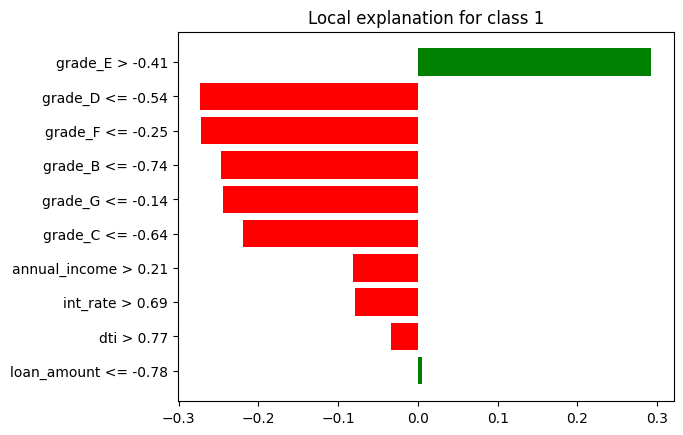

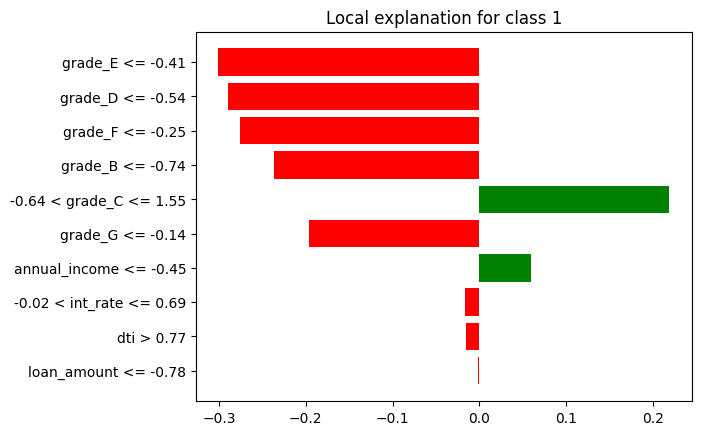

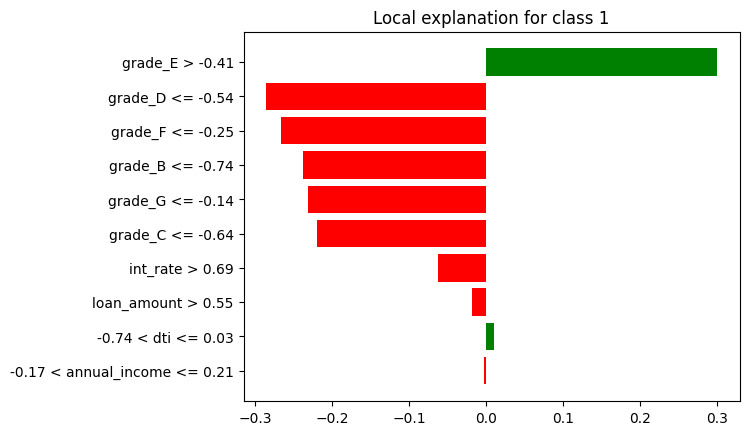

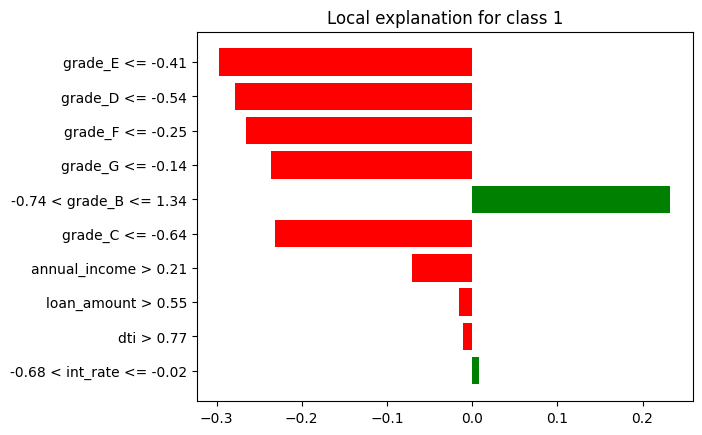

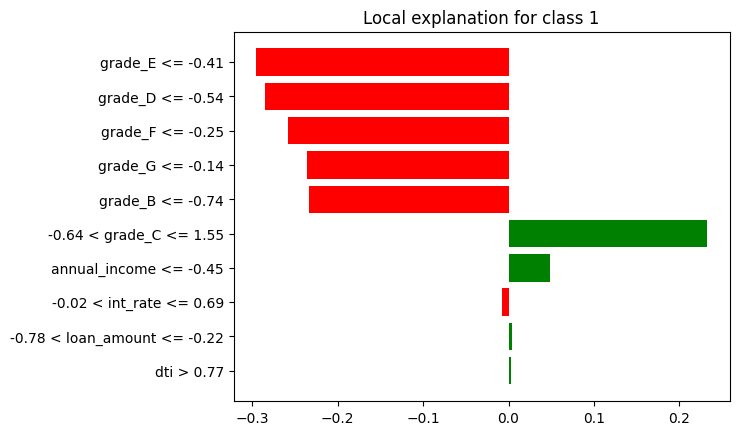

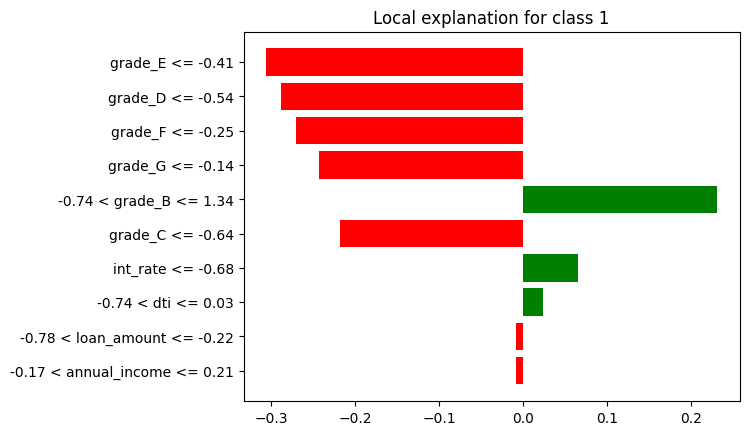

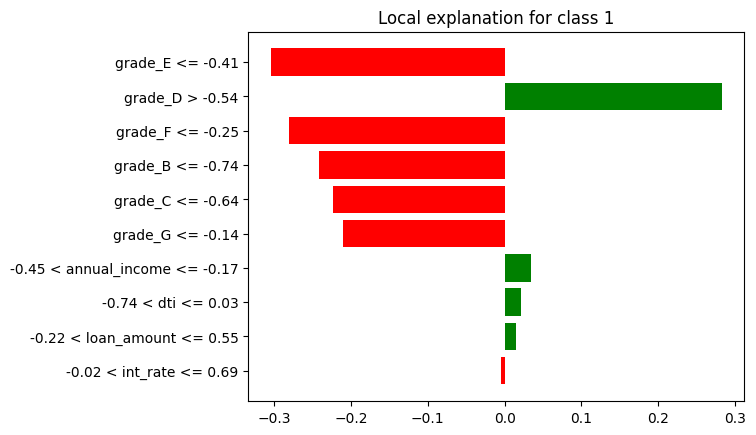

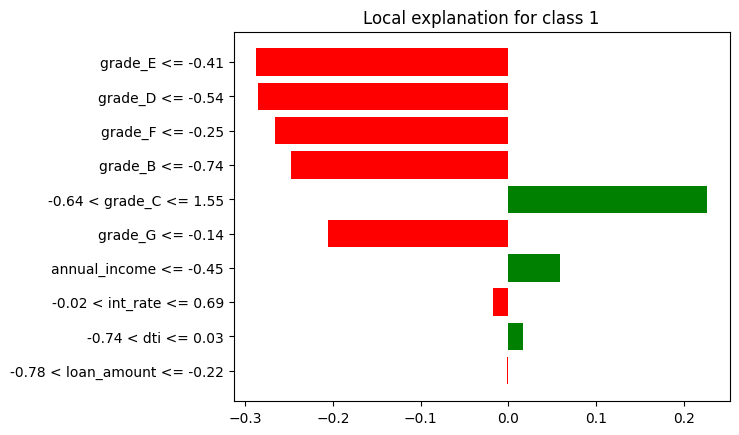

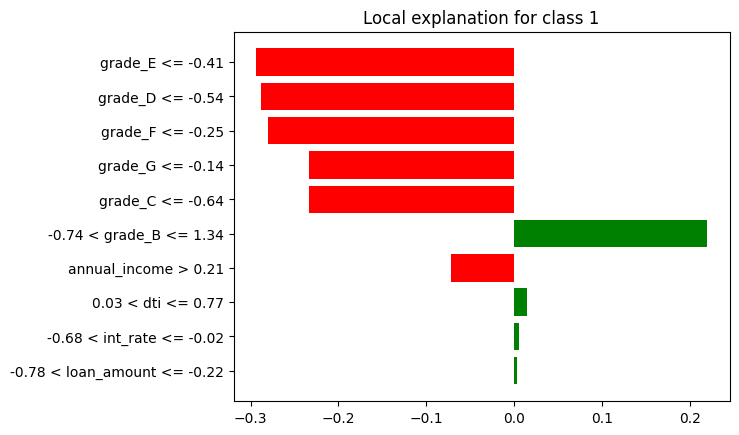

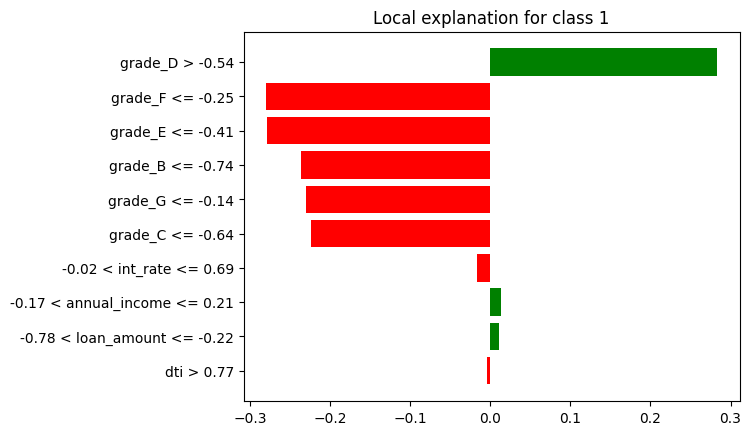

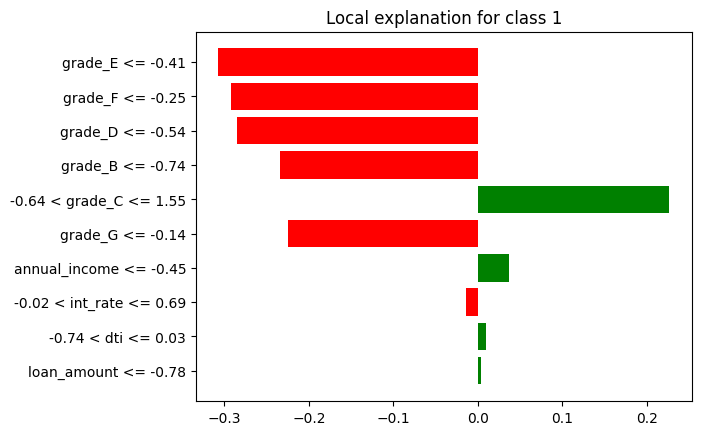

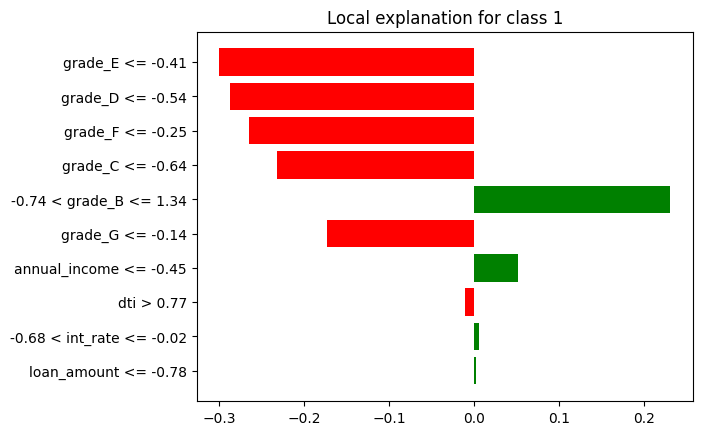

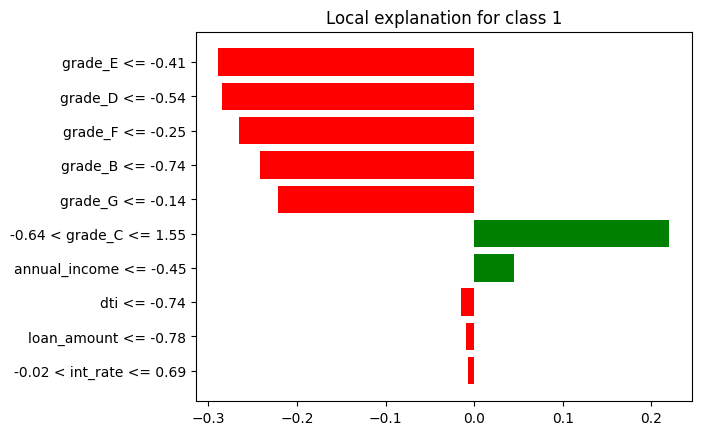

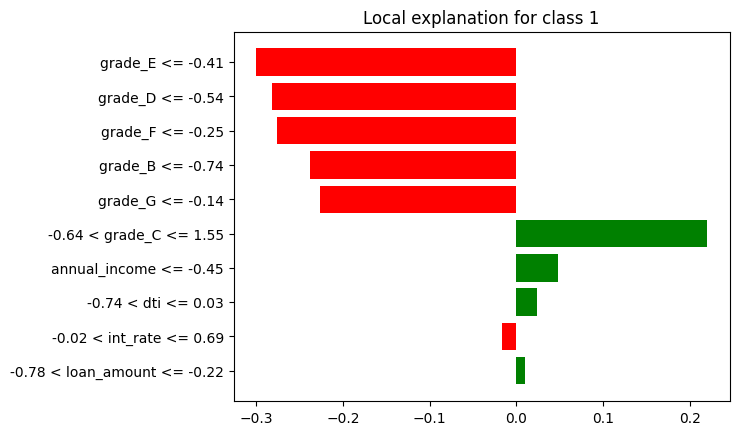

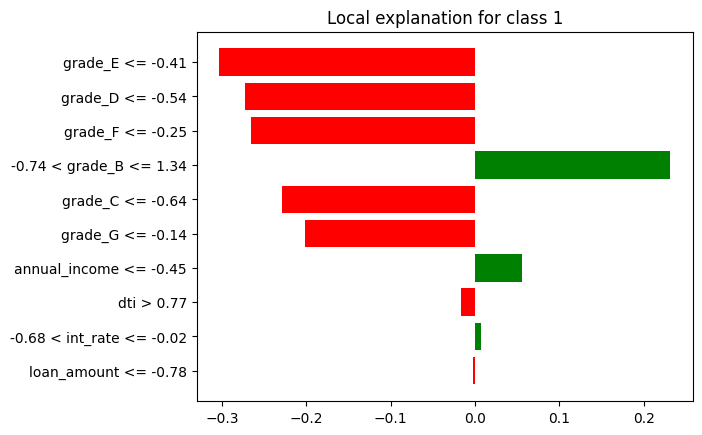

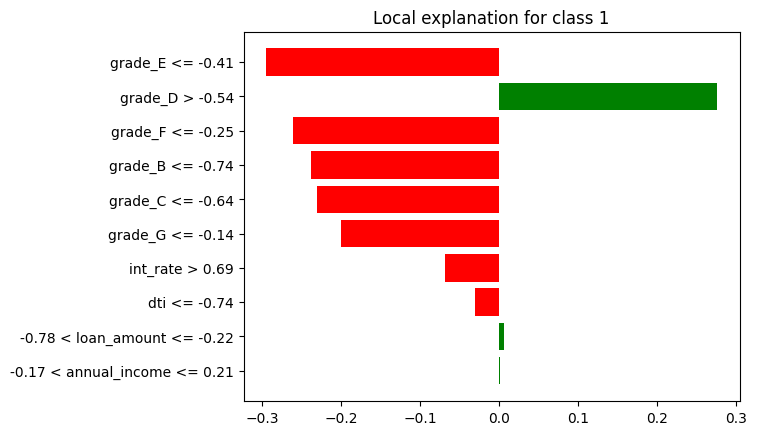

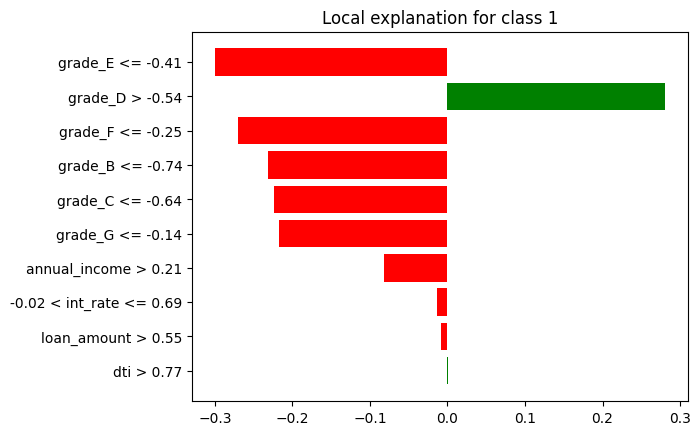

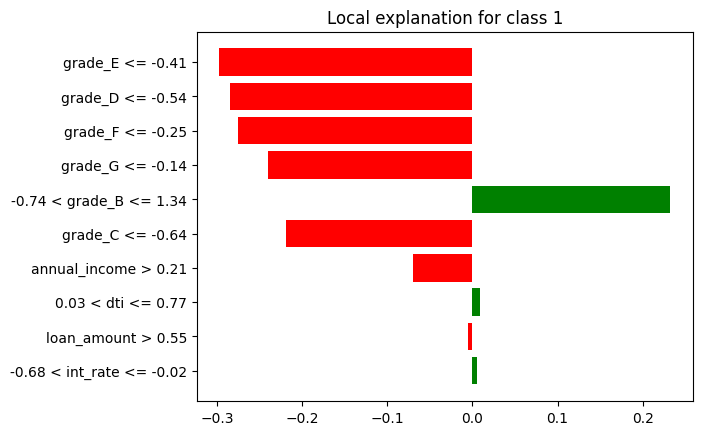

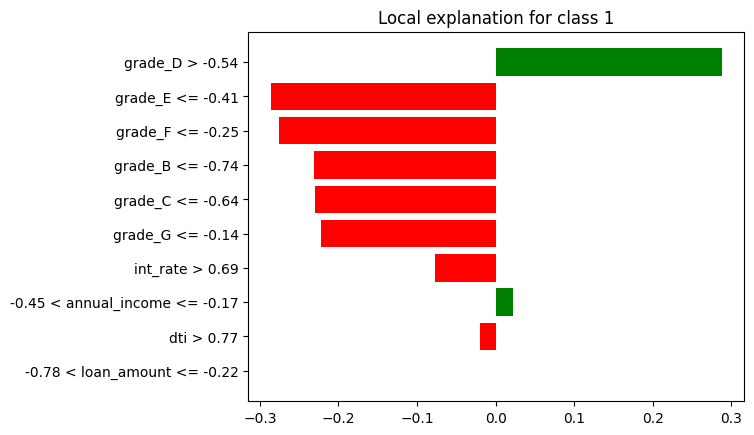

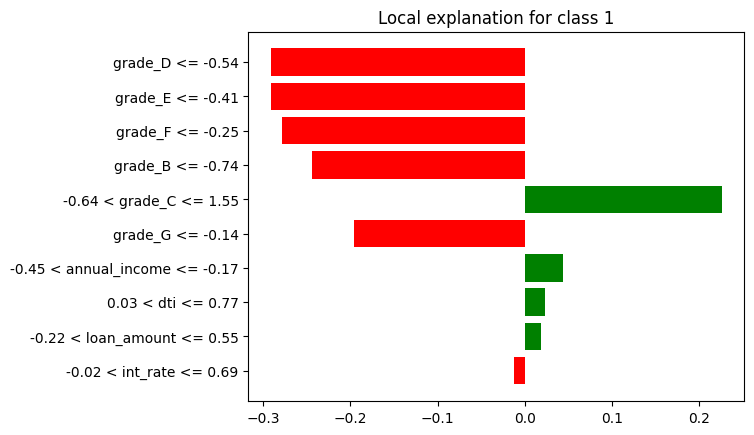

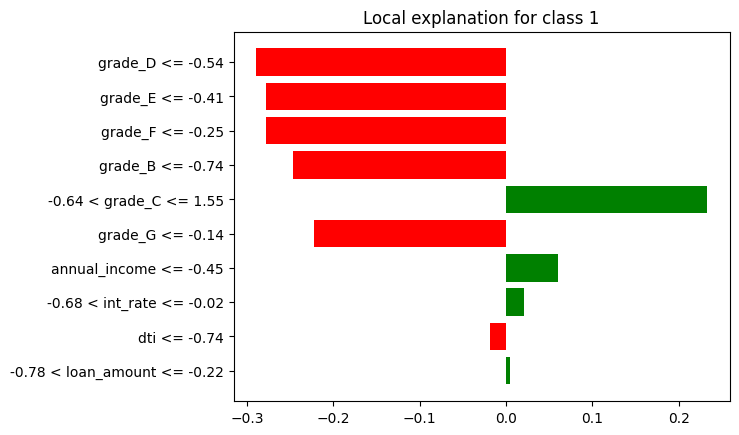

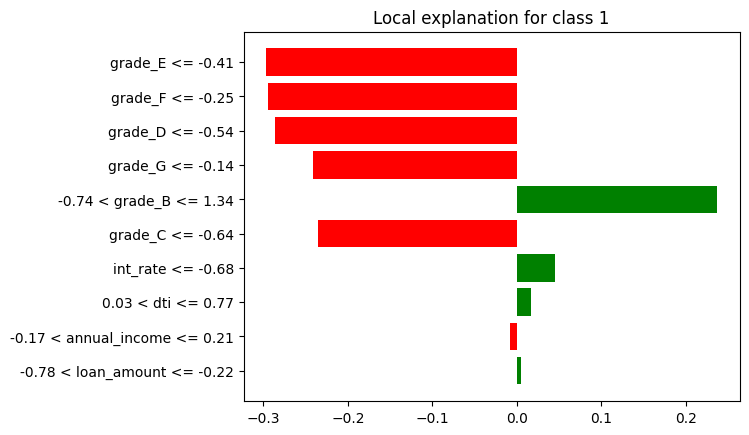

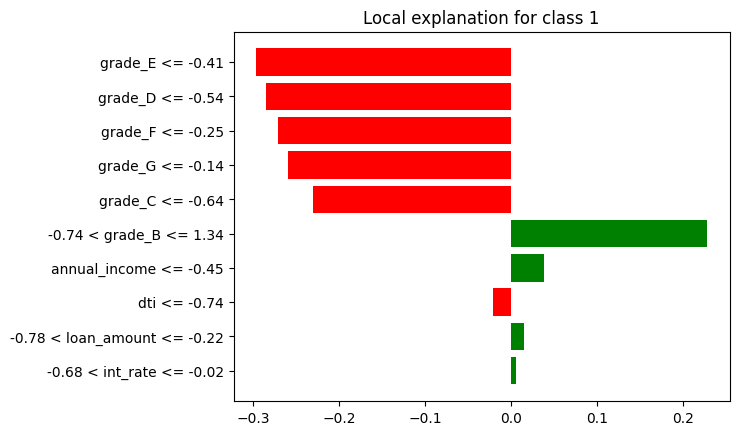

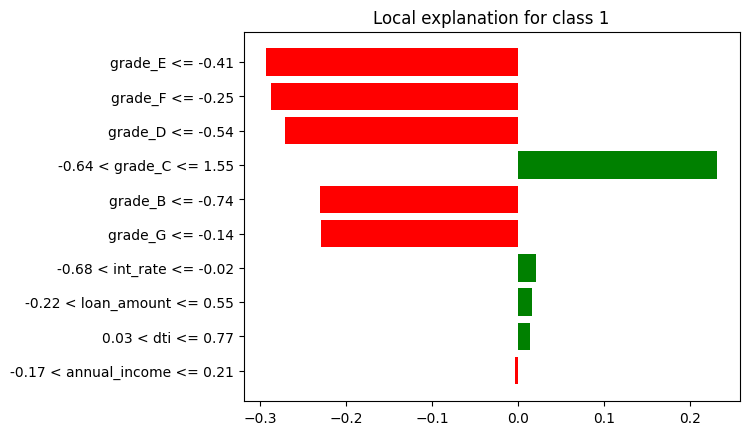

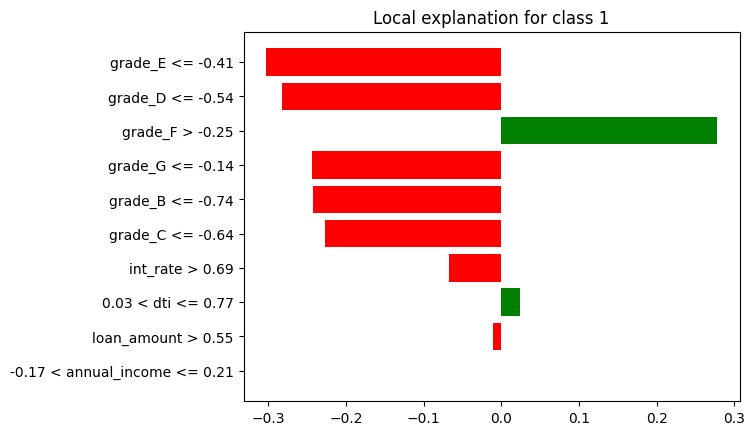

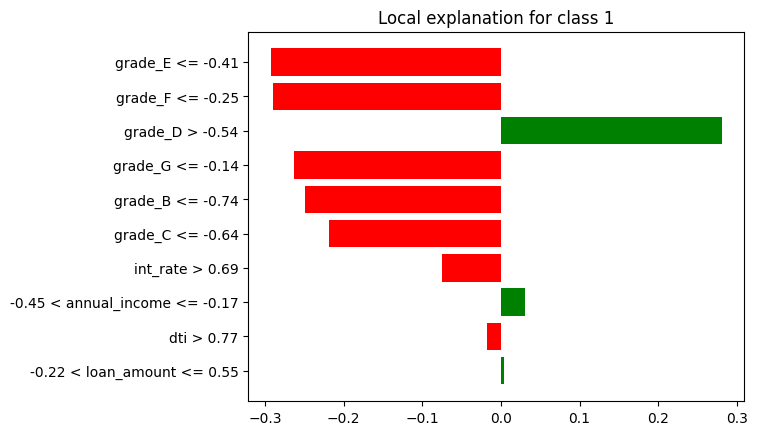

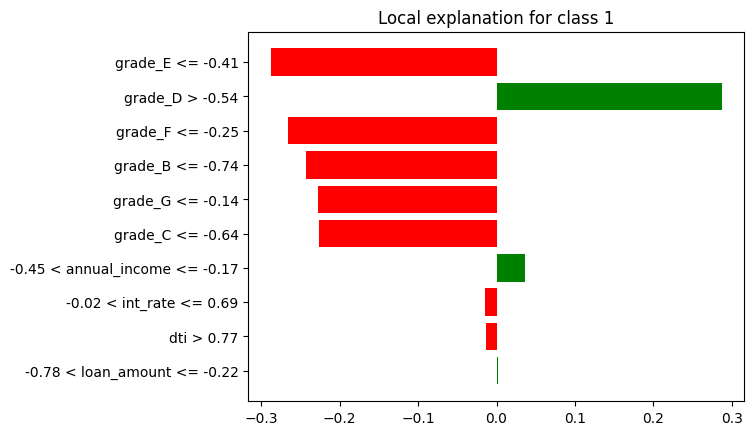

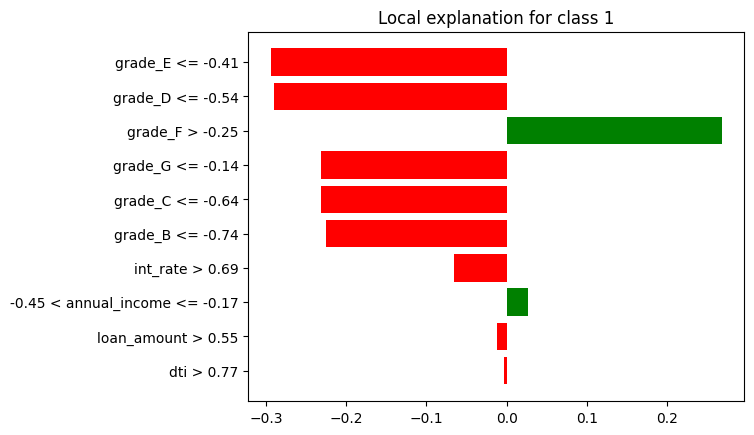

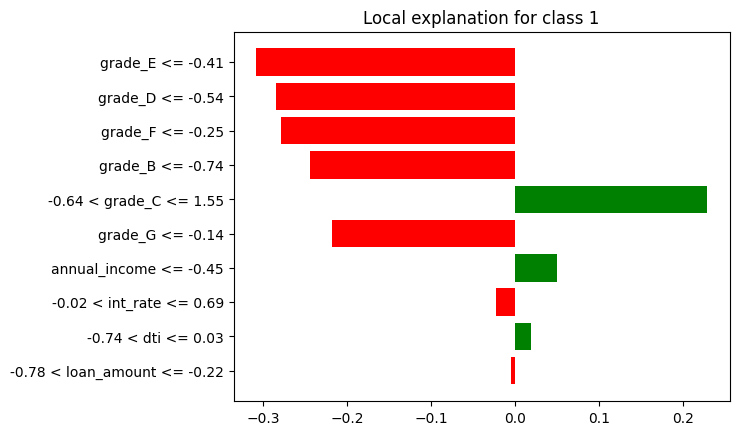

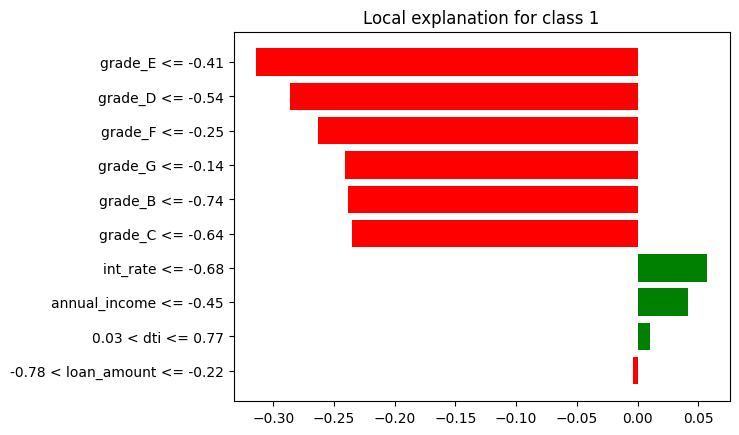

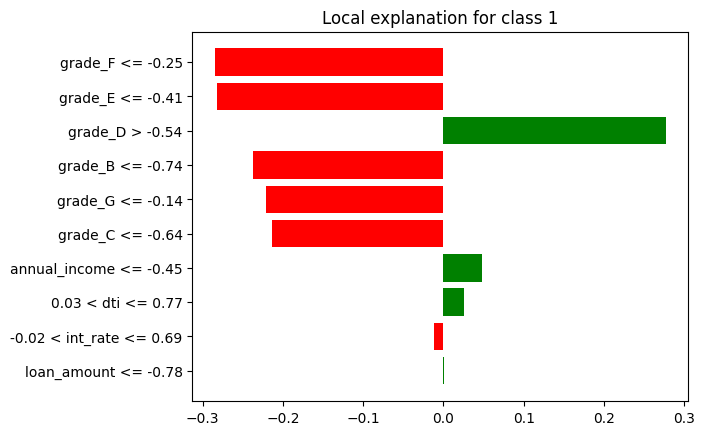

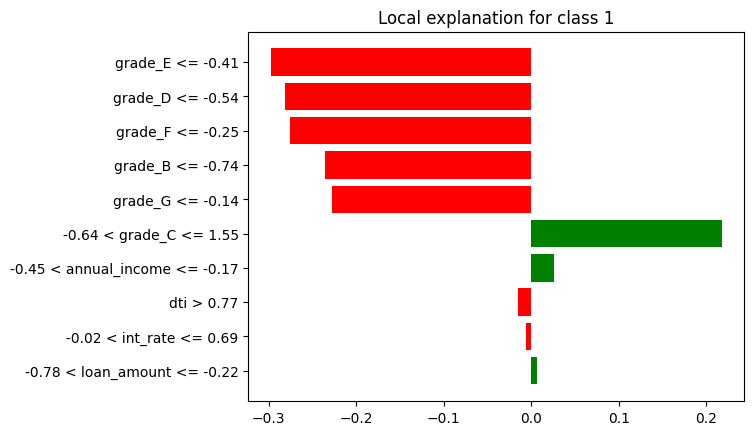

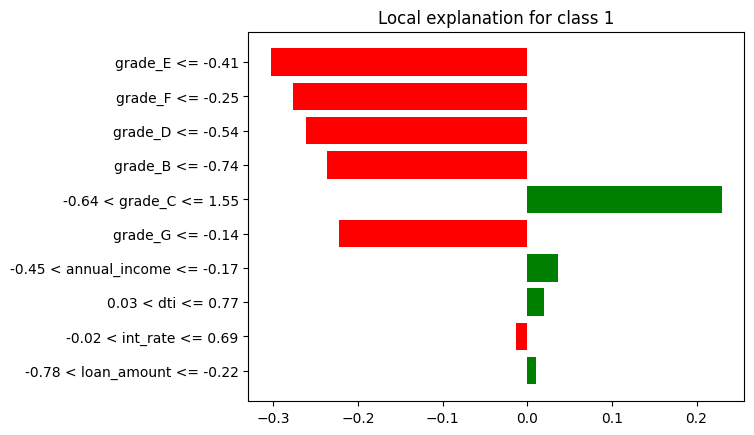

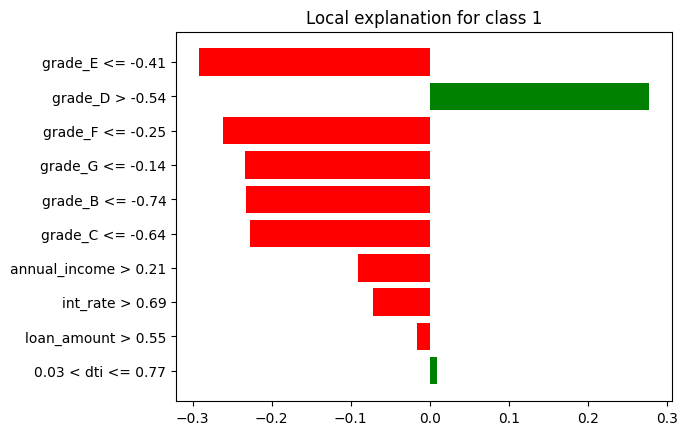

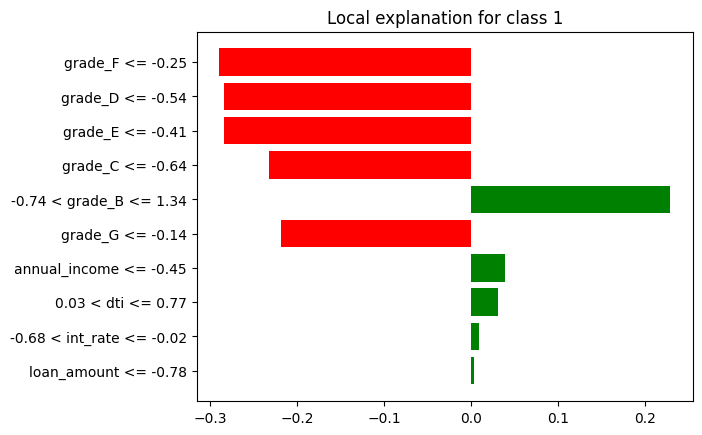

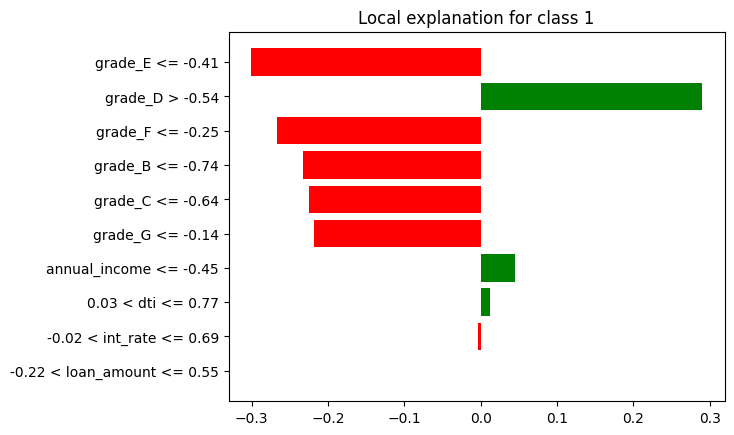

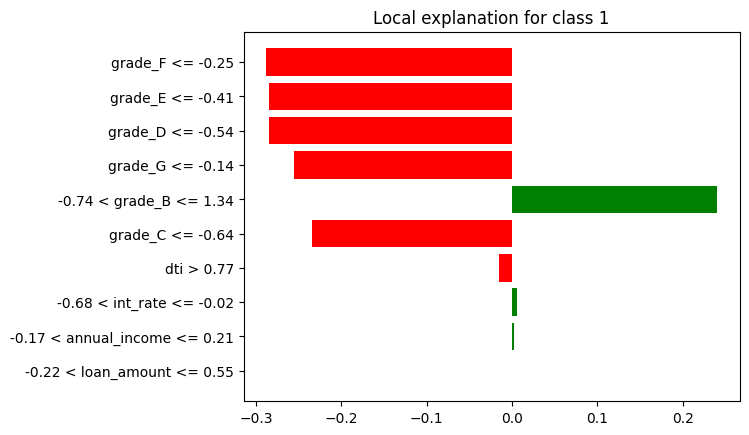

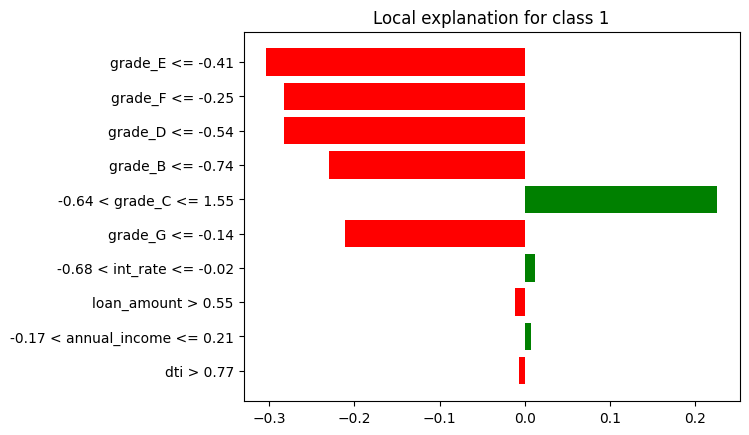

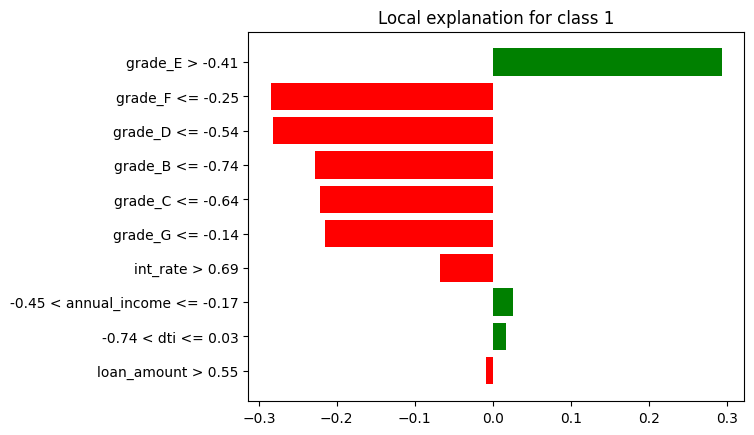

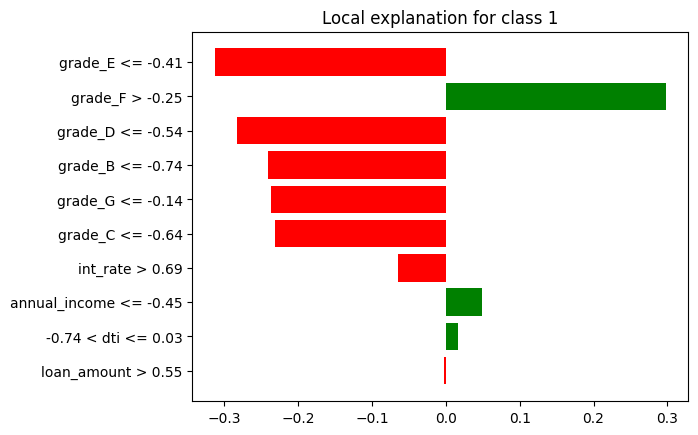

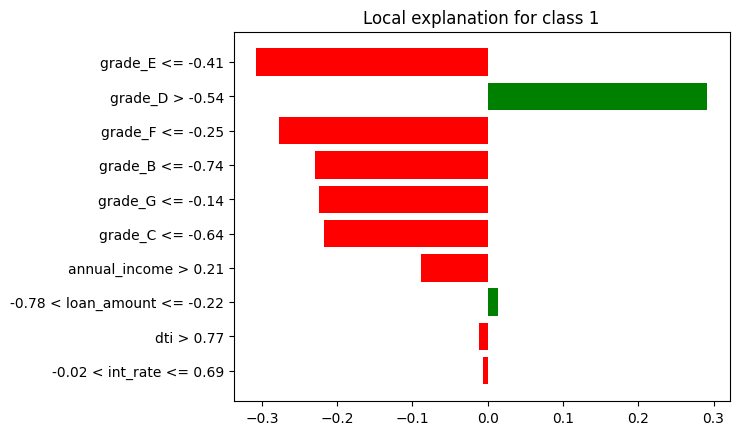

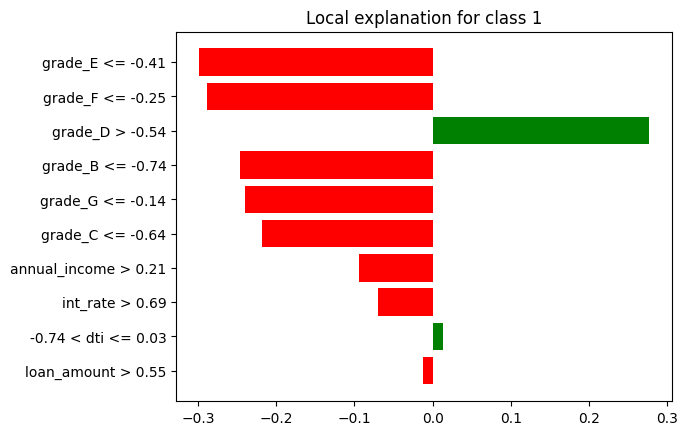

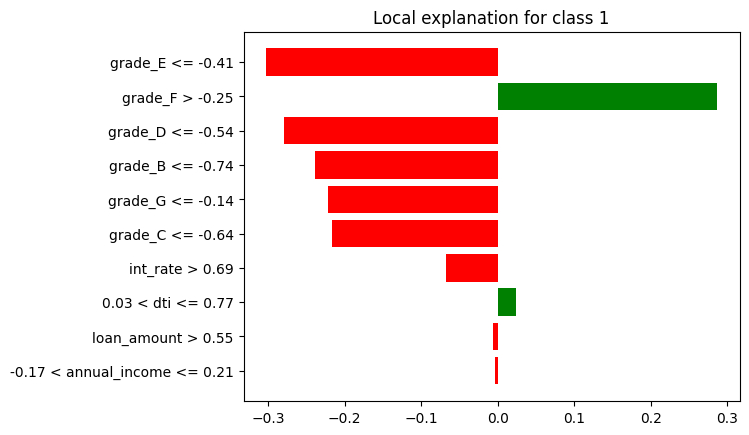

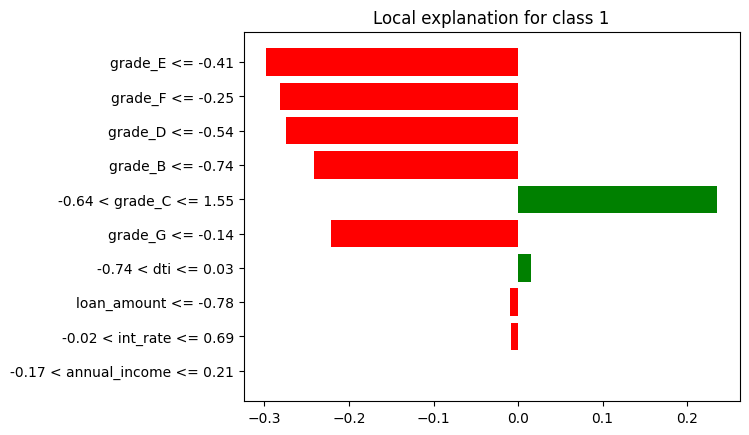

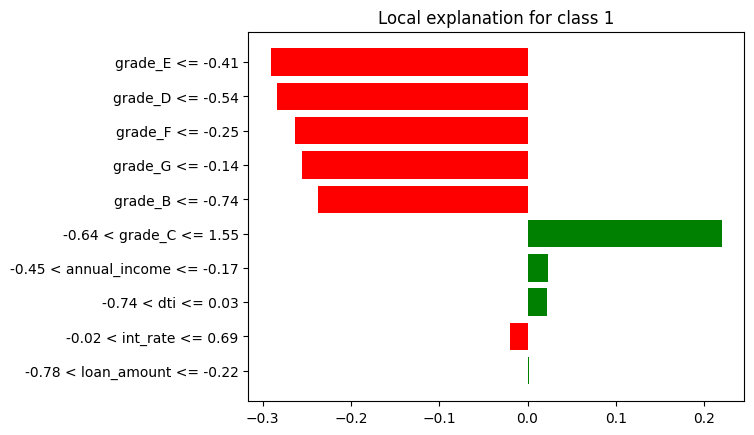

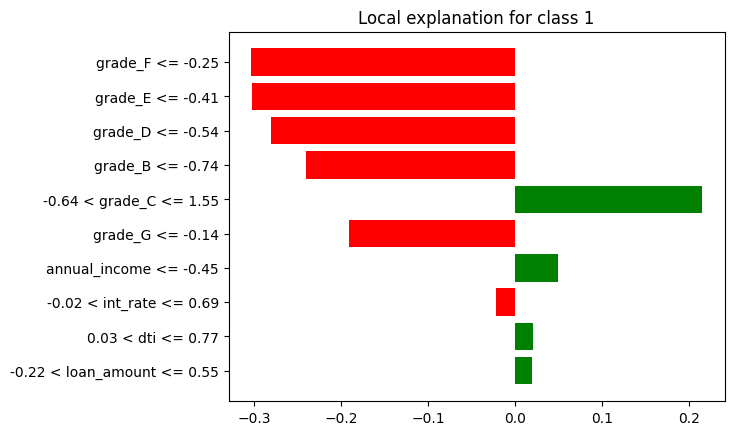

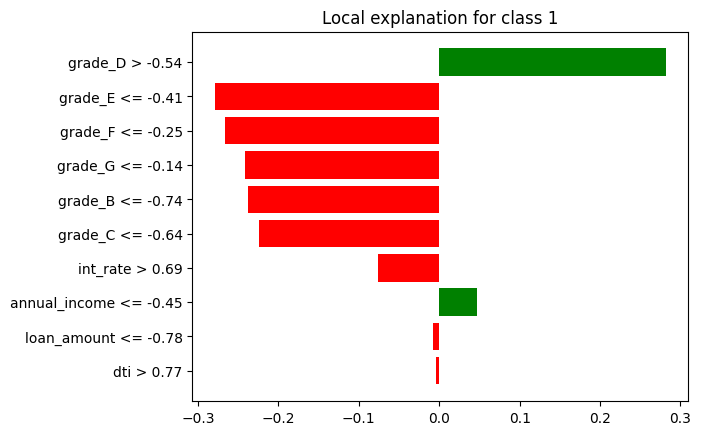

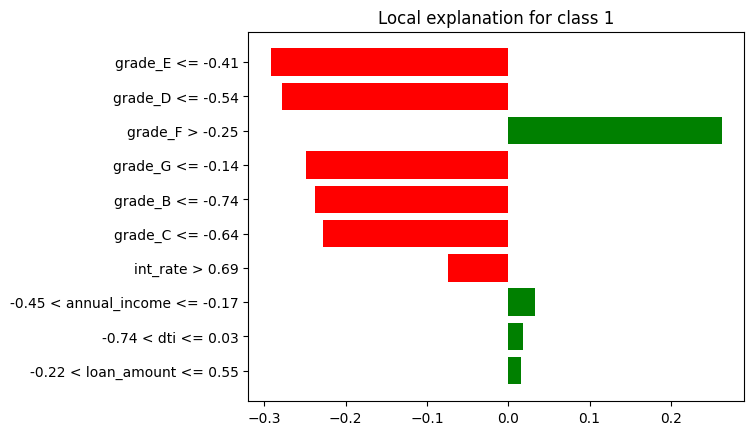

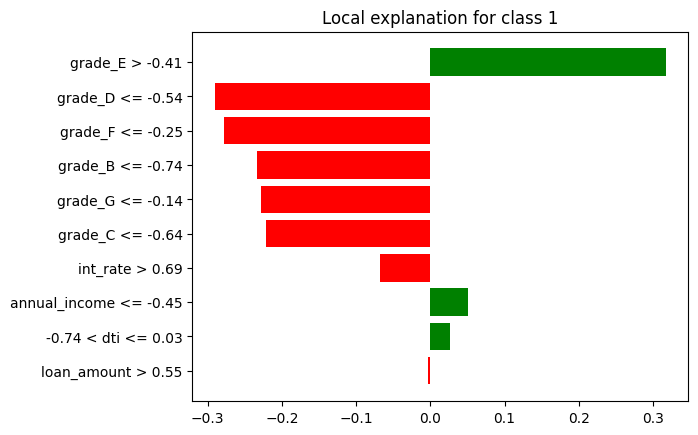

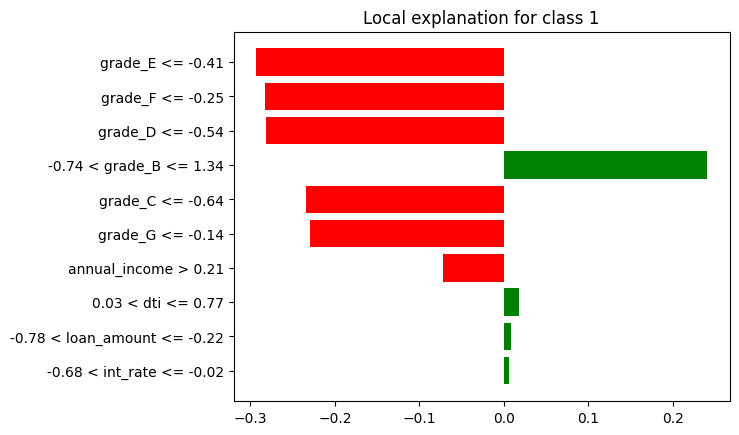

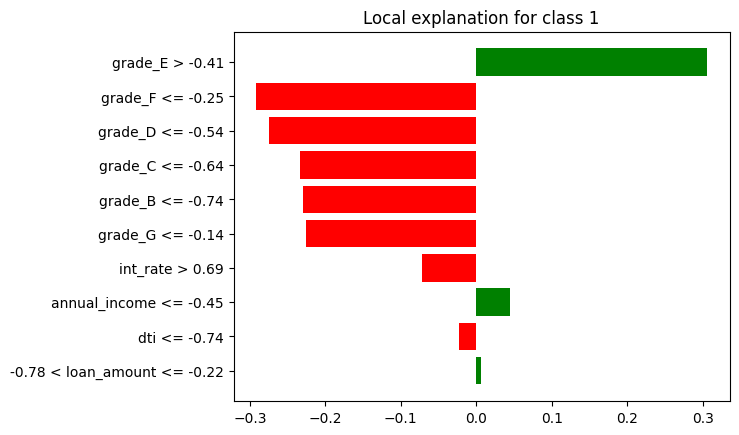

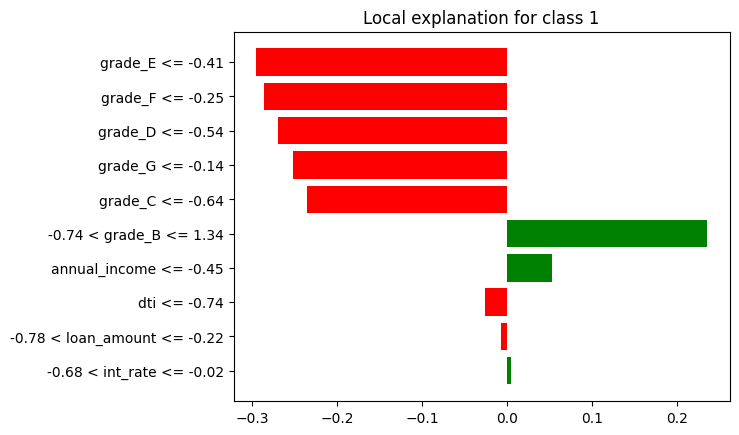

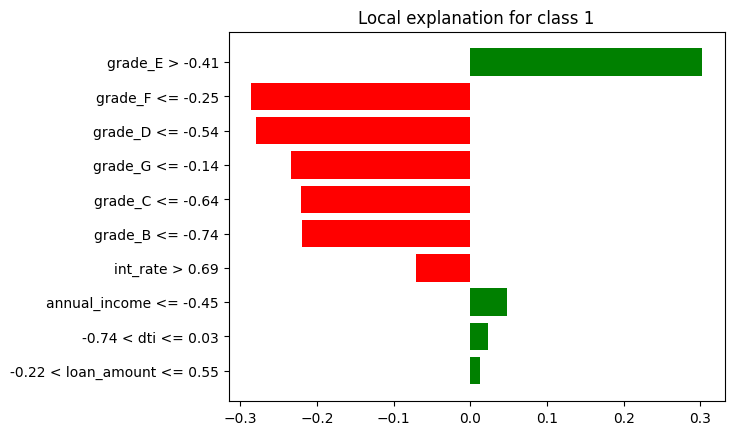

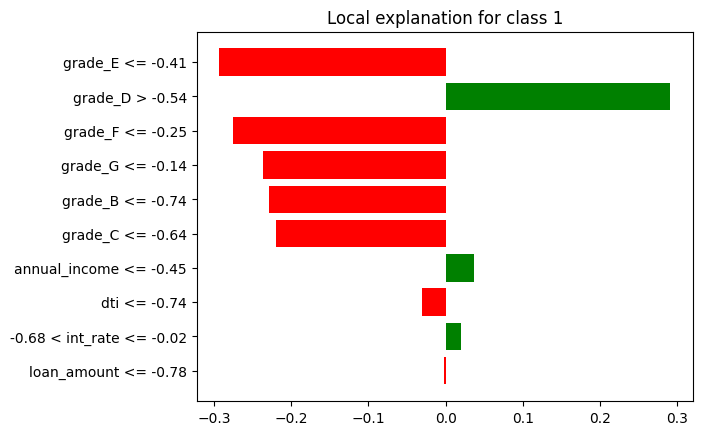

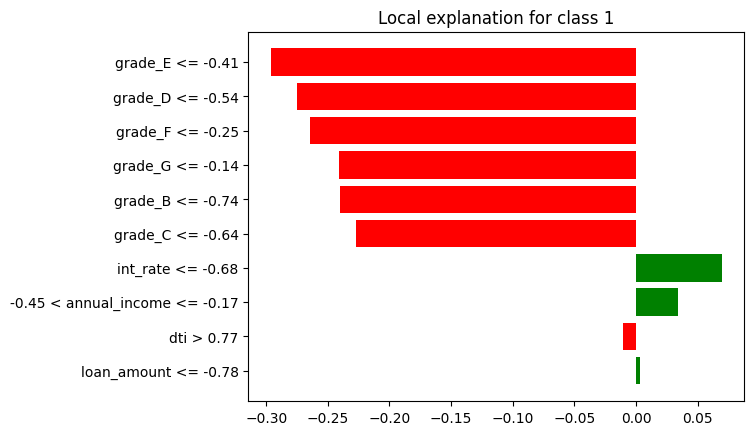

TypeError: visualize_instance_html() got an unexpected keyword argument 'Text'

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt


# One-Hot Encode the categorical features like 'grade'
X_train_smote_encoded = pd.get_dummies(X_train_smote, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align columns in case there are missing columns in either training or testing sets
X_train_encoded, X_test_encoded = X_train_smote_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Train the RandomForest model again
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train_smote)

# Initialize the LIME Explainer
explainer = LimeTabularExplainer(
    X_train_scaled,  # Training data
    training_labels=y_train_smote.values,  # Labels for the training data
    feature_names=X_train_encoded.columns,  # Feature names (ensure the order matches the training data)
    class_names=[str(i) for i in np.unique(y_train_smote)],  # Class names (for binary: 0 and 1)
    mode='classification',  # Problem type (classification)
    discretize_continuous=True  # Discretize continuous features
)

# Limit to the first 500 instances of X_test for quicker evaluation
X_test_sampled = X_test_scaled[:500]  # Limit to 500 instances

# Select a test instance to explain (for example, first instance of class 1)
test_instance = X_test_sampled[0]  # Select the first instance

# Generate explanation for the test instance
exp = explainer.explain_instance(test_instance, rf.predict_proba)

# Visualize the explanation as a bar plot for feature importance
exp.as_pyplot_figure()
plt.show()

# Optionally, if you want to filter and evaluate only class 1 predictions (charged off), you can do:
# Filter X_test_sampled and y_test for class 1 (charged off)
X_test_class_1 = X_test_sampled[y_test.iloc[:500] == 1]
y_test_class_1 = y_test.iloc[:500][y_test == 1]

# Now, explain individual instances for class 1 (charged off)
for i, instance in enumerate(X_test_class_1):
    exp = explainer.explain_instance(instance, rf.predict_proba)
    exp.as_pyplot_figure()  # Show the feature importance for the current instance
    plt.show()



In [ ]:
import json

# Convert explanation to a dictionary
explanation_dict = {
    'class_names': explanation.available_labels(),
    'features': explanation.as_list()
}

# Save to a JSON file
with open('outputs/lime_explanations/explanation_0.json', 'w') as f:
    json.dump(explanation_dict, f)
